This notebook presents the Laser environment elaborated following the `gymnasium` API developed to carry out pulse optimisation using Deep Reinforcement Learning (RL).

Author: Francesco Capuano, 2022 S17 summer intern @ ELI-beamlines, Prague

In [8]:
import sys
import os
sys.path.append(os.path.abspath('../..'))
# importing the custom environment
from environment.laser_env import LaserEnv
import matplotlib.pyplot as plt
import torch

As reported [here](https://github.com/fracapuano/ELIopt/blob/main/notebooks/DifferentialEvolution/loss_functions.ipynb), the overall region in which the control parameters are valued can be defined with a set of three disequality constraints defined as **maximal percentage difference from the builder's nominal value**. 

This values are here reported for the reader convenience.

In [9]:
# env parametrization
# alpha_GDD, alpha_TOD, alpha_FOD
compressor_params = -1* torch.tensor((267.422 * 1e-24, -2.384 * 1e-36, 9.54893 * 1e-50))
# alpha_GDD \pm 0.1 alpha_GDD, alpha_TOD \pm 0.2 alpha_TOD, alpha_FOD \pm 0.3 alpha_FOD, 
lb = (2.3522e-22, -1.003635e-34, 4.774465e-50)
ub = (2.99624e-22, 9.55955e-35, 1.4323395e-49)

bounds = torch.tensor(
    (lb, ub), dtype=torch.float64
)
# non-linear phase accumulation parameter - noisy estimate of real value
B_integral = 2

In [10]:
env = LaserEnv(
    bounds = bounds, 
    compressor_params = compressor_params, 
    B_integral = B_integral)

In [13]:
from typing import Tuple

def visualize_pulses(
    pulse:Tuple[torch.tensor, torch.tensor], 
    target_pulse:Tuple[torch.tensor, torch.tensor]
):
    """This function visualizes two different pulses rolling up the two to peak-index
    
    Args: 
        pulse (Tuple[torch.tensor, torch.tensor]): Tuple of tensors. First tensor is pulse time axis, second
                                                   tensor is temporal profile of pulse itself. This pulse will
                                                   be plotted with a solid line.
        target_pulse (Tuple[torch.tensor, torch.tensor]): Tuple of tensors. First tensor is pulse time axis, second
                                                   tensor is temporal profile of a target pulse. This will
                                                   be plotted with a scatter plot.
    """
    # unpacking inputs
    time, actual_pulse = pulse
    target_time, target_pulse = target_pulse
    
    # retrieving index where time is 0 (not exactly 0, dependings on fft Dt value)
    zero_pos = torch.argwhere(torch.abs(time) == torch.abs(time).min()).item()
    # retrieving peak of pulse
    max_pos = torch.argmax(actual_pulse).item()
    # retrieving peak of target pulse
    target_max_pos = torch.argmax(target_pulse).item()
    # rolling the two pulses to make them centered in 0
    centering_target = -(target_max_pos - zero_pos) if target_max_pos - zero_pos >= 0 else zero_pos - target_max_pos
    # always centering the pulse on zero
    rolled_pulse = torch.roll(
            actual_pulse, 
            shifts = centering_target
            )
    
    fig, ax = plt.subplots()
    # plotting
    ax.plot(
        time.numpy(), 
        rolled_pulse.numpy(), 
        lw = 2, 
        label = "Actual Pulse")

    ax.scatter(
        time.numpy(), 
        torch.roll(target_pulse, 
                shifts = centering_target).numpy(),
        label = "Target Pulse", 
        c = "tab:grey",
        marker = "x", 
        s = 50)
    
    ax.set_xlim(-8e-12, 8e-12)

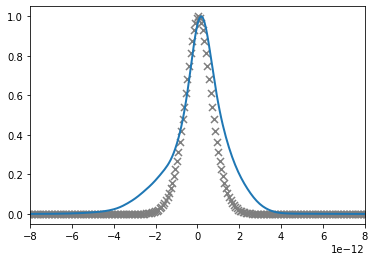

In [14]:
# forwarding a random control, latest from D.E. optimization
control = (2.7257385253906698e-22, -1.652241706847897e-36, 1.4479880332946824e-48)

(time, profile), *_ = env.step(action=control)
time_TL, profile_TL = env.laser.transform_limited()

# plot
visualize_pulses((time, profile), (time_TL, profile_TL))

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(time, profile)
ax.scatter(time_TL, profile_TL, marker="x", s=50, color="grey")

ax.set_xlim(-8e-12, 8e-12)

The `LaserEnv` environment is defined as a wrapper around two main components presented in this repo: 

1. `LaserModel_torch`

2. `PulseEmbedder`

In particular, the object `LaserModel_wrapper` combines these two objects to obtain something which can be used in a reliable way as environment for RL agents.
In the following cell, this environment is used to train a PPO agent to perform the considered task.

In [ ]:
from stable_baselines3 import PPO

env = LaserEnv()
model_PPO = PPO("MlpPolicy", env, verbose=2)
model_PPO.learn(total_timesteps=int(5e4))

model_PPO.save("model_Sep20")